# Classifying Sonar Returns as Rocks or Mines with Random Forest

In [4]:
from math import sqrt, fabs, exp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import seaborn as sns

sns.set()

In [5]:
# read data from uci data repository
x_list = []
data_path = './data/sonar.all-data'

with open(data_path) as data:
    
    for line in data:
        # split on comma
        row = line.strip().split(',')
        x_list.append(row)
        
# separate labels from attributes, convert from attributes from strings to numeric and convert 'M' to 1 and 'R' to 0
x_num = []
labels = []

for row in x_list:
    last_col = row.pop()
    
    if last_col == 'M':
        labels.append(1)
        
    else:
        labels.append(0)
        
    attr_row = [float(elt) for elt in row]
    x_num.append(attr_row)

# number of rows and columns in x matrix
n_rows = len(x_num)
n_cols = len(x_num[1])

In [6]:
# form x and y into numpy arrays and make up column names
x = np.array(x_num)
y = np.array(labels)

rocks_vs_mines_names = np.array(['V' + str(i) for i in range(n_cols)])

# break into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=531)

auc = []
n_tree_list = range(50, 2000, 50)

for i_trees in n_tree_list:
    depth = None
    max_feat = 8
    rocks_vs_mines_rf_model = ensemble.RandomForestClassifier(n_estimators=i_trees, max_depth=depth, 
                                                              max_features=max_feat, oob_score=False, random_state=531)
    rocks_vs_mines_rf_model.fit(x_train, y_train)
    
    # Accumulate auc on test set
    prediction = rocks_vs_mines_rf_model.predict_proba(x_test)
    auc_calc = roc_auc_score(y_test, prediction[:, 1:2])
    auc.append(auc_calc)
    
print(f'AUC: {auc[-1]}')

AUC: 0.9457403651115619


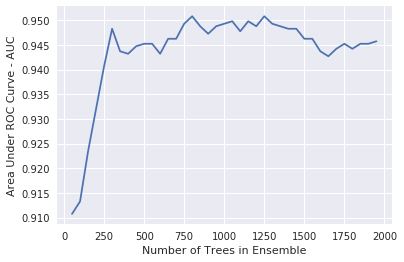

In [7]:
# plot training and test errors vs number of trees in ensemble
plt.plot(n_tree_list, auc)
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Area Under ROC Curve - AUC')
plt.show()

[10 11  8 20  9 51 48 19 42 47  0 12 35 46  3 16 44  4 45 36 27 26 15 43 50
  5 22 18 38 41 34 17 21 14 25  1 53  7  6 13 39 23 52 30 54 31 24 33 32  2
 28 37 49 29 57 58 40 59 55 56]


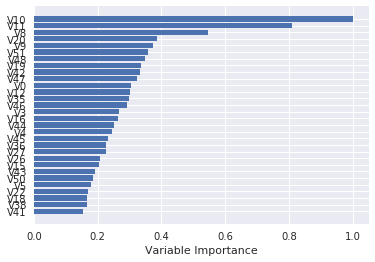

In [8]:
# plot feature importance
feature_importance = rocks_vs_mines_rf_model.feature_importances_

# normalize by max importance
feature_importance = feature_importance/feature_importance.max()

# plot importance of top 30
idx_sorted = np.argsort(feature_importance)[30:60]
idx_temp = np.argsort(feature_importance)[::-1]
print(idx_temp)

bar_pos = np.arange(idx_sorted.shape[0]) + 0.5
plt.barh(bar_pos, feature_importance[idx_sorted], align='center')
plt.yticks(bar_pos, rocks_vs_mines_names[idx_sorted])
plt.xlabel('Variable Importance')
plt.show()

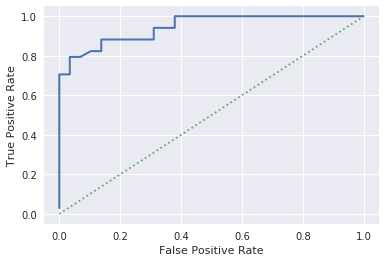

In [9]:
# plot best version of ROC curve
fpr, tpr, thresh = roc_curve(y_test, list(prediction[:, 1:2]))
ct_class =[i * 0.01 for i in range(101)]

plt.plot(fpr, tpr, linewidth=2)
plt.plot(ct_class, ct_class, linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [10]:
# pick some threshold values and calc confusion matrix for best predictions
# notice that GBM predictions don't fall in range of (0, 1)
# pick threshold values at 25th, 50th, and 75th percentiles
idx_25 = int(len(thresh) * 0.25)
idx_50 = int(len(thresh) * 0.50)
idx_75 = int(len(thresh) * 0.75)

# calculate total points, total positives, and total negatives
total_pts = len(y_test)
p = sum(y_test)
n = total_pts - p

print('Confusion Matrices for Different Treshold Values')
print('\n')

# 25th
tp = tpr[idx_25] * p
fn = p - tp
fp = fpr[idx_25] * n
tn = n - fp

print(f'Theshold Value = {thresh[idx_25]}')
print(f'TP = {tp/total_pts}\t FP = {fp/total_pts}')
print(f'FN = {fn/total_pts}\t\t TN = {tn/total_pts}')
print('\n')

# 50th
tp = tpr[idx_50] * p
fn = p - tp
fp = fpr[idx_50] * n
tn = n - fp

print(f'Theshold Value = {thresh[idx_50]}')
print(f'TP = {tp/total_pts}\t\t FP = {fp/total_pts}')
print(f'FN = {fn/total_pts}\t TN = {tn/total_pts}')
print('\n')

# 75th
tp = tpr[idx_75] * p
fn = p - tp
fp = fpr[idx_75] * n
tn = n - fp

print(f'Theshold Value = {thresh[idx_75]}')
print(f'TP = {tp/total_pts}\t\t FP = {fp/total_pts}')
print(f'FN = {fn/total_pts}\t TN = {tn/total_pts}')

Confusion Matrices for Different Treshold Values


Theshold Value = 0.6369230769230769
TP = 0.42857142857142855	 FP = 0.015873015873015872
FN = 0.1111111111111111		 TN = 0.4444444444444444


Theshold Value = 0.6251282051282051
TP = 0.4444444444444444		 FP = 0.06349206349206349
FN = 0.09523809523809523	 TN = 0.3968253968253968


Theshold Value = 0.5574358974358974
TP = 0.5079365079365079		 FP = 0.14285714285714285
FN = 0.031746031746031744	 TN = 0.31746031746031744
